## Importing all dependencies for the Notebook
Important for running the notebook. Not necessarilly relevant to our analysis. 

In [ ]:
import os, sys
import findspark
from pathlib import Path
import subprocess
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, count, min as spark_min, max as spark_max,
    avg, length, to_timestamp, expr, to_date, sum as spark_sum, year, month
)
from pyspark.sql.window import Window
import time 
import pandas as pd 
import matplotlib.pyplot as plt 


## PySpark setup inside of notebook. 
- Notebook initialization in the next two cells
- Swap JAVA_HOME path into local path. Check for nano zsh.


In [ ]:
print("Python executable:", sys.executable)
print("Python version   :", sys.version)
print("JAVA_HOME before :", os.environ.get("JAVA_HOME"))

JAVA_HOME = "/opt/homebrew/Cellar/openjdk@11/11.0.29/libexec/openjdk.jdk/Contents/Home" # andrei 
# JAVA_HOME="/Library/Java/JavaVirtualMachines/temurin-11.jdk/Contents/Home" # ezgim
os.environ["JAVA_HOME"] = JAVA_HOME
os.environ["PATH"] = os.path.join(JAVA_HOME, "bin") + ":" + os.environ["PATH"]

print("JAVA_HOME after  :", os.environ.get("JAVA_HOME"))

import subprocess
print("\njava -version from this kernel:")
print(subprocess.check_output(["java", "-version"], stderr=subprocess.STDOUT).decode())

findspark.init()

from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
        .appName("test_jvm")
        .getOrCreate()
)

print("\nSpark version:", spark.version)

# Tiny test job
spark.range(5).show()


In [ ]:
try:
    project_root = Path(
        subprocess.check_output(["git", "rev-parse", "--show-toplevel"])
        .decode()
        .strip()
    )
except Exception:
    project_root = Path.cwd().parent

print("PROJECT ROOT:", project_root)

raw_dir = project_root / "data" / "raw"
print("RAW DATA DIR:", raw_dir)

spark = (
    SparkSession.builder
        .appName("IRA_Tweets_Task1")
        .master("local[*]")
        .config("spark.driver.memory", "6g")      # adjust down/up depending on your RAM
        .config("spark.executor.memory", "6g")    # local = same as driver
        .config("spark.sql.shuffle.partitions", "4")
        .getOrCreate()
)

df = (
    spark.read
        .option("header", "true")
        .option("inferSchema", "true")
        .option("multiLine", "true")
        .option("escape", "\"")
        .csv(str(raw_dir))
)

df.printSchema()
print("Total rows:", df.count())

spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY") 

## Exploratory analysis 
We begin by quantifying the dataaset, provding a foundation for understanding how large the operation was and how intensively each account was used. 

- Exploring the dataset by looking for:
    - Total number of tweets
    - Total number of unique accounts
    - Average tweets per account
    - Media tweets per account
    - Max tweets by a single amount
    - Std dev of tweets per account
    - Mean account lifespan (days)
    - Average tweet length (characters)
    - Average followers per account 

These statistics show the scale and shape of the operations and help us detect assymetries. The following table summarizes the main dataset priorities. 

In [ ]:
# timestamp column
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
df_time = df.withColumn(
    "publish_ts",
    to_timestamp("publish_date", "M/d/yyyy H:mm")
)

# global accounts
total_tweets = df.count()
n_accounts = df.selectExpr("count(distinct author) as n").first()["n"]

# / account stats
acct_stats_spark = (
    df_time.groupBy("author")
           .agg(
               count("*").alias("n_tweets"),
               spark_min("publish_ts").alias("first_ts"),
               spark_max("publish_ts").alias("last_ts"),
               avg("followers").alias("avg_followers")
           )
)

acct_stats = acct_stats_spark.toPandas()

# lifespan
acct_stats["lifespan_days"] = (
    (acct_stats["last_ts"] - acct_stats["first_ts"])
    .dt.total_seconds() / 86400.0
).clip(lower=0)

# acc level metrics
avg_tweets = acct_stats["n_tweets"].mean()
median_tweets = acct_stats["n_tweets"].median()
max_tweets = acct_stats["n_tweets"].max()
std_tweets = acct_stats["n_tweets"].std()

mean_lifespan = acct_stats["lifespan_days"].mean()
avg_followers_per_account = acct_stats["avg_followers"].mean()

# avg tweet length 
avg_tweet_length = (
    df.select(avg(length("content")).alias("avg_len"))
      .first()["avg_len"]
)

# defining stats table 
stats_df = pd.DataFrame({
    "Metric": [
        "Total number of tweets",
        "Total number of unique accounts",
        "Average tweets per account",
        "Median tweets per account",
        "Max tweets by a single account",
        "Std dev of tweets per account",
        "Mean account lifespan (days)",
        "Average tweet length (characters)",
        "Average followers per account",
    ],
    "Value": [
        f"{total_tweets:,}",
        f"{n_accounts:,}",
        f"{avg_tweets:.2f}",
        f"{median_tweets:.2f}",
        f"{max_tweets:,}",
        f"{std_tweets:.2f}",
        f"{mean_lifespan:.2f}",
        f"{avg_tweet_length:.2f}",
        f"{avg_followers_per_account:.2f}",
    ]
})

plt.close('all')

# plt 
fig, ax = plt.subplots(figsize=(9, 3))
ax.axis("off")

# add title above table
fig, ax = plt.subplots(figsize=(9, 3))

# move table lower
ax.set_position([0, -0.05, 1, 1])
ax.axis("off")

plt.title("Key Dataset Statistics", pad=20)

table = ax.table(
    cellText=stats_df.values,
    colLabels=stats_df.columns,
    loc="center",
    cellLoc="center"
)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

plt.show()

## Temporal Analysis: 
The temporal analysis reveals the heartbeat of the operation. Plotting tweet activity over time allows us to see major surges in activity aligned with political events and periods of heightened coordination. 

To investigate this narrative, we overlay key geopolitical and political events using dotted vertical lines. These annotation allow us to interpret volume spikes in context.

This section includes:
- Daily Tweet volume over time 
- 30 day rolling average of Tweet counts
- Posting patterns
    - Hour of day 
    - Day of the week

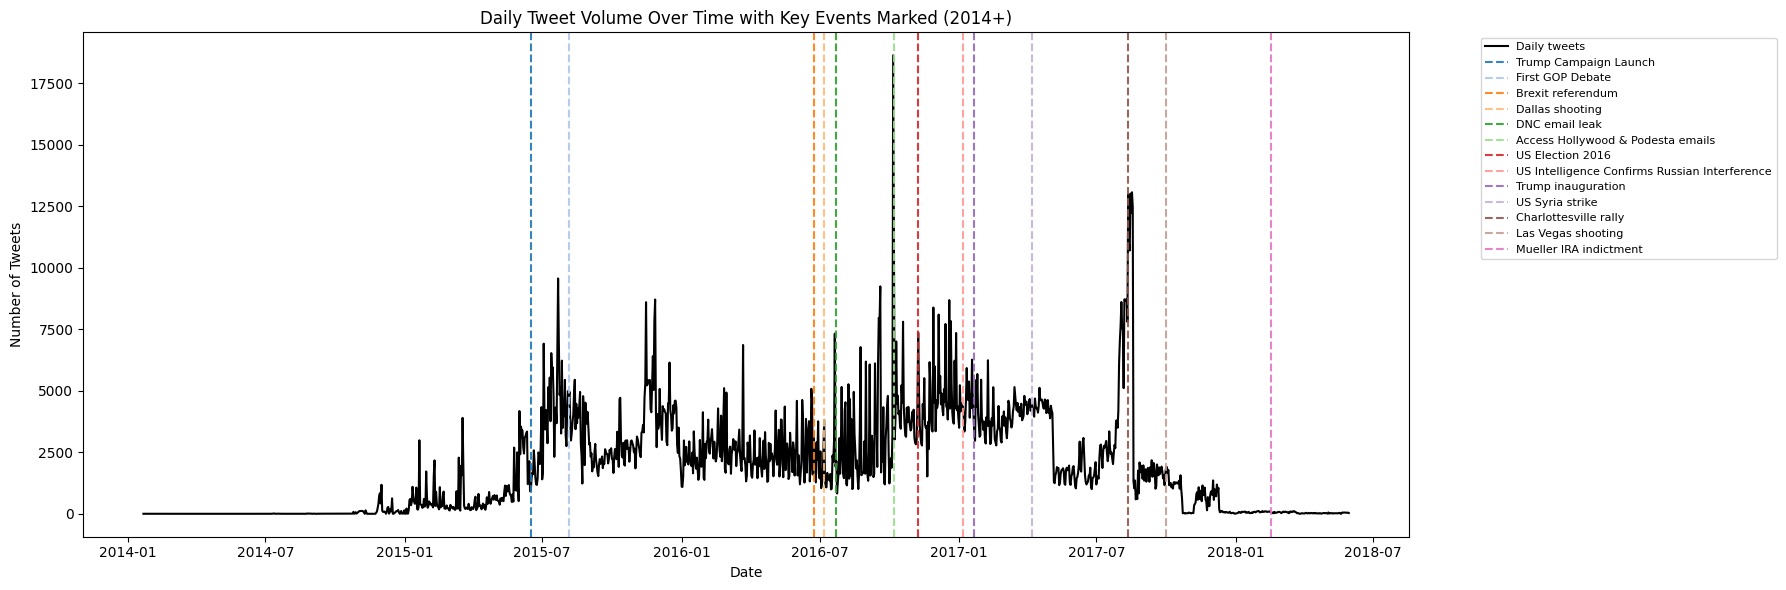

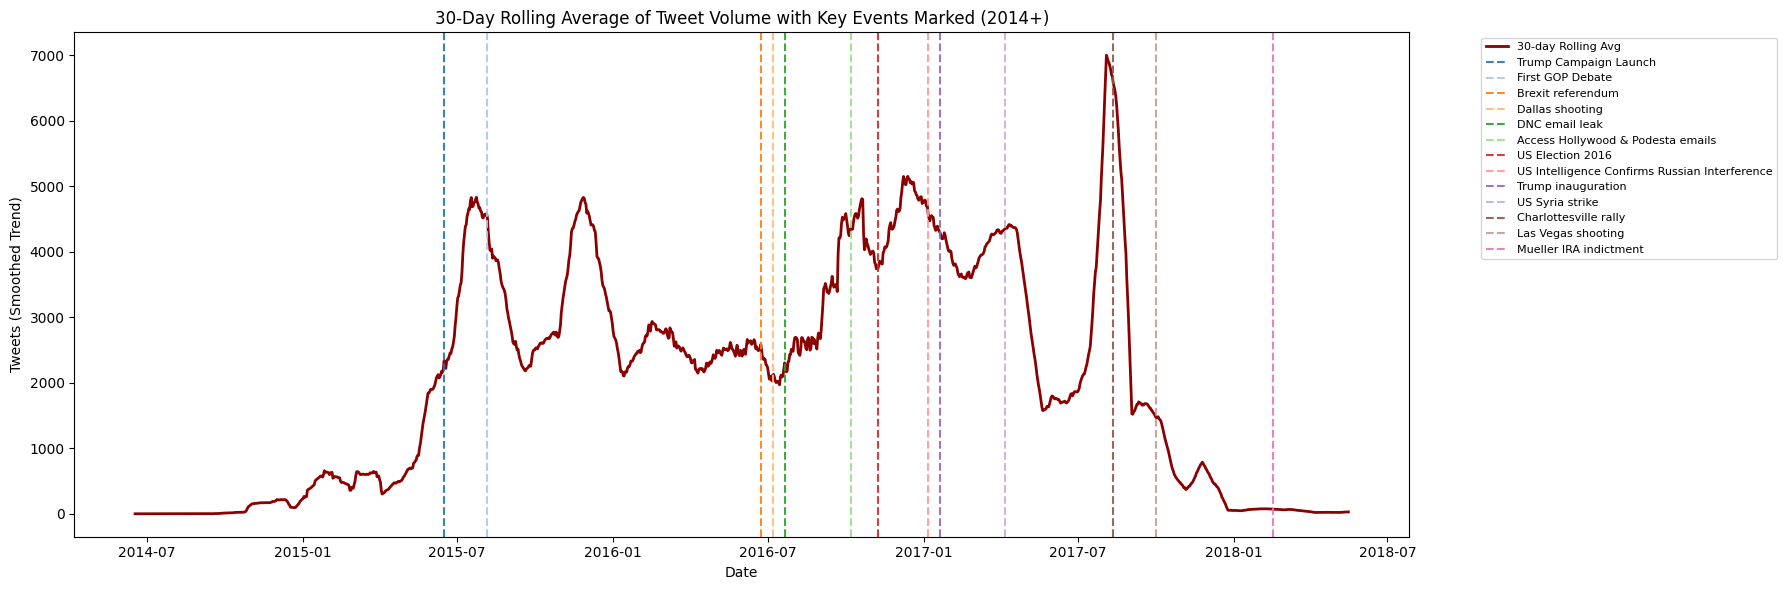

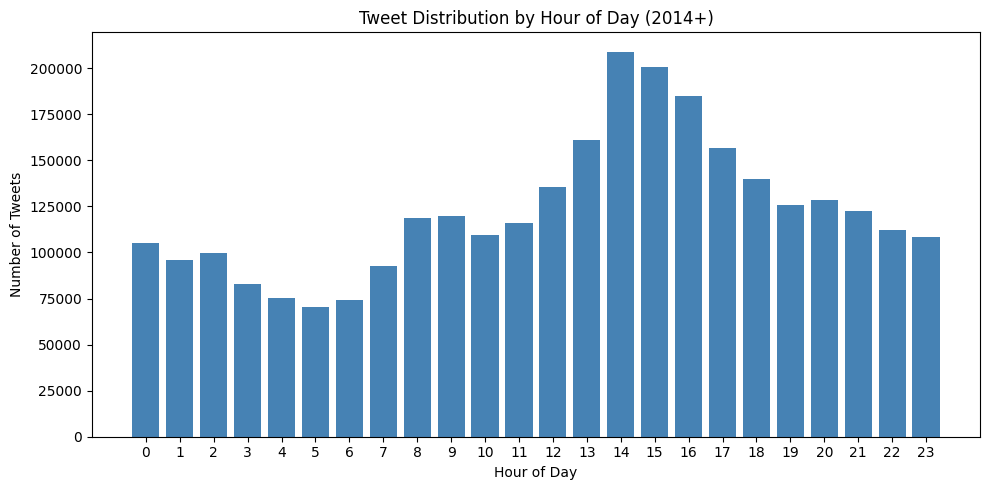

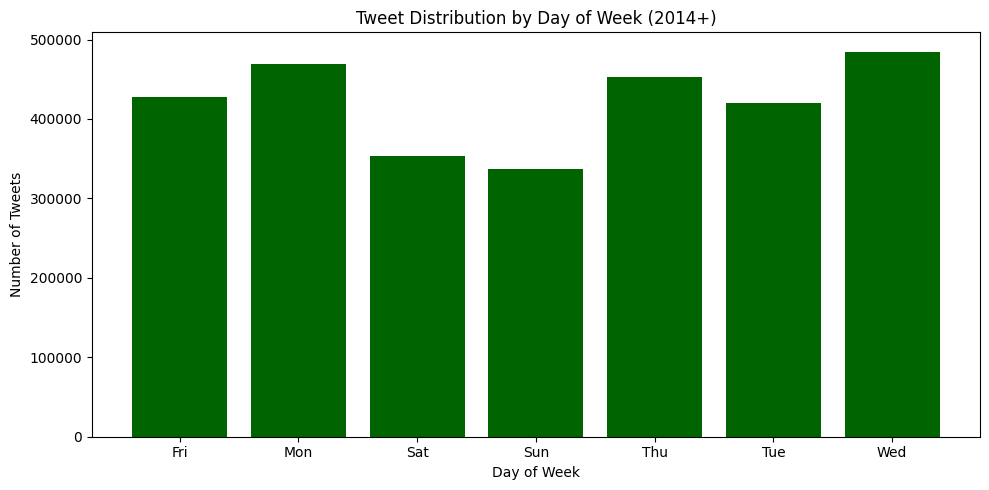

In [30]:
from pyspark.sql.functions import to_timestamp, to_date, hour, date_format
import pandas as pd
import matplotlib.pyplot as plt

# timestamps
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

df_time = df.withColumn(
    "publish_ts",
    to_timestamp("publish_date", "M/d/yyyy H:mm")
)

# keep only tweets from 2014 onwards
df_time = (
    df_time
        .filter(df_time.publish_ts.isNotNull())
        .filter(df_time.publish_ts >= "2014-01-01")
)

# daily tweet counts
df_daily = (
    df_time
        .withColumn("date", to_date("publish_ts"))
        .groupBy("date")
        .count()
        .orderBy("date")
)

daily_pd = df_daily.toPandas()
daily_pd["date"] = pd.to_datetime(daily_pd["date"])
daily_pd = daily_pd.sort_values("date")

# 30-day rolling avg for second plot
daily_pd["rolling_30"] = daily_pd["count"].rolling(30, center=True).mean()

# load events csv
events_path = "/Users/sanduandrei/Desktop/BigData/data/events/events_temporal_markers.csv"
events_pd = pd.read_csv(events_path)
events_pd["event_date"] = pd.to_datetime(events_pd["date"], format="%m/%d/%Y")

# daily plot for tweet count
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(daily_pd["date"], daily_pd["count"], linewidth=1.5, color="black", label="Daily tweets")

colors = plt.cm.tab20.colors
for idx, (_, row) in enumerate(events_pd.iterrows()):
    ax.axvline(
        row["event_date"],
        color=colors[idx % len(colors)],
        linestyle="--",
        linewidth=1.5,
        alpha=0.9,
        label=row["label"]
    )

ax.set_title("Daily Tweet Volume Over Time with Key Events Marked (2014+)")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Tweets")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()

# 30 day rolling average 
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(daily_pd["date"], daily_pd["rolling_30"], linewidth=2, color="darkred", label="30-day Rolling Avg")

for idx, (_, row) in enumerate(events_pd.iterrows()):
    ax.axvline(
        row["event_date"],
        color=colors[idx % len(colors)],
        linestyle="--",
        linewidth=1.5,
        alpha=0.9,
        label=row["label"]
    )

ax.set_title("30-Day Rolling Average of Tweet Volume with Key Events Marked (2014+)")
ax.set_xlabel("Date")
ax.set_ylabel("Tweets (Smoothed Trend)")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()

# patterns by hour of the day
df_hourly = (
    df_time
        .withColumn("hour", hour("publish_ts"))
        .groupBy("hour")
        .count()
        .orderBy("hour")
)

hourly_pd = df_hourly.toPandas()
plt.figure(figsize=(10,5))
plt.bar(hourly_pd["hour"], hourly_pd["count"], color="steelblue")
plt.title("Tweet Distribution by Hour of Day (2014+)")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Tweets")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

# patterns by day of the week
df_dow = (
    df_time
        .withColumn("day_of_week", date_format("publish_ts", "E"))
        .groupBy("day_of_week")
        .count()
)

dow_pd = df_dow.toPandas().sort_values("day_of_week")
plt.figure(figsize=(10,5))
plt.bar(dow_pd["day_of_week"], dow_pd["count"], color="darkgreen")
plt.title("Tweet Distribution by Day of Week (2014+)")
plt.xlabel("Day of Week")
plt.ylabel("Number of Tweets")
plt.tight_layout()
plt.show()


## Activation and Deactivation Cascades
One important aspect to check when looking at coordinated influence campaigns is the simultaneous activation or retirement of many accounts. 
By examining the first and last tweet timestamps for each account, we can observe waves of activation and deactivation of accounts. 

- These cascades often occur:
    - before major political events
    - during narrative pivots
    - or after account exposure 

Detecting these waves can help us identify the operational cycles of the troll factory. 

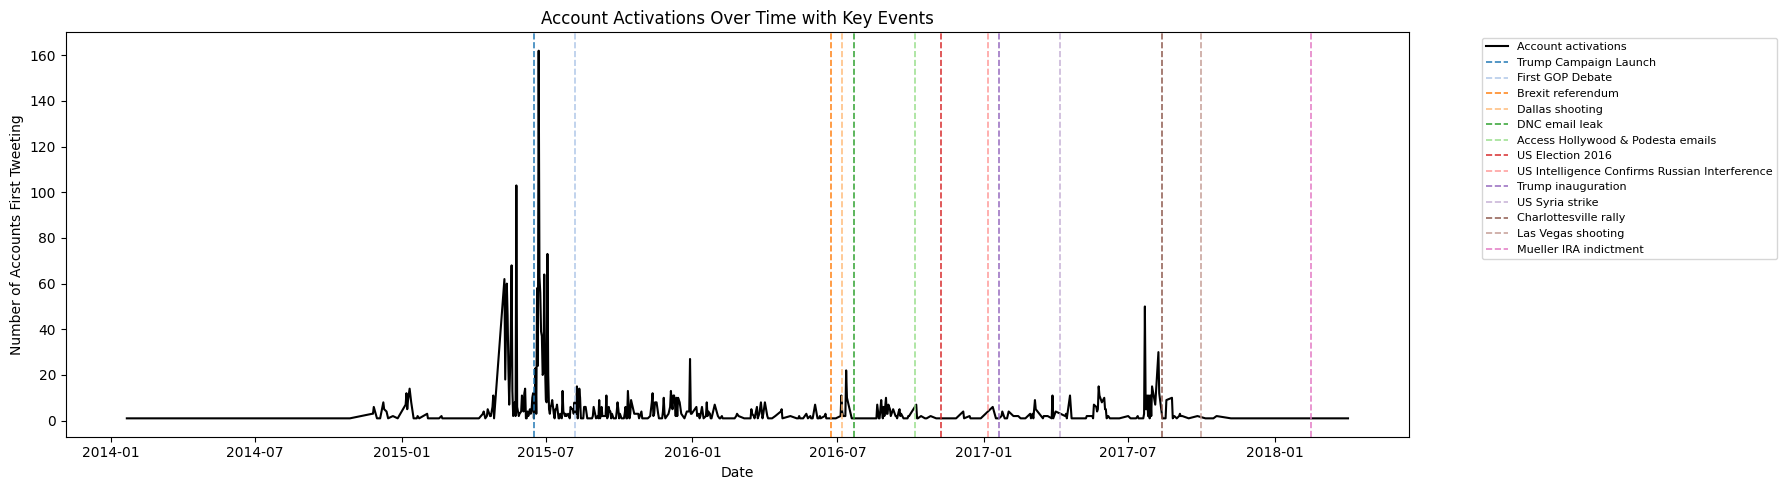

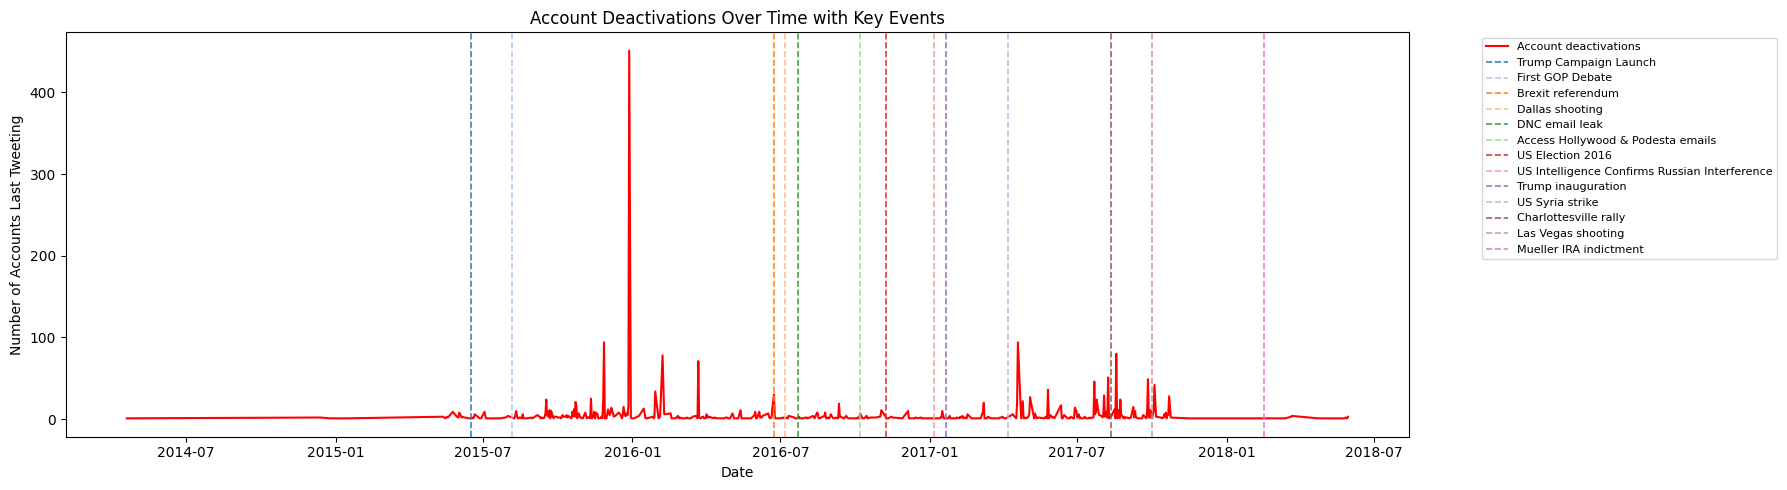

In [31]:
from pyspark.sql.functions import (
    to_timestamp, to_date,
    min as spark_min, max as spark_max
)
import pandas as pd
import matplotlib.pyplot as plt

# timestamp column check 
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

if "df_time" not in globals():
    df_time = df.withColumn(
        "publish_ts",
        to_timestamp("publish_date", "M/d/yyyy H:mm")
    )

df_time = df_time.filter(df_time.publish_ts.isNotNull())
df_time = df_time.filter(df_time.publish_ts >= "2014-01-01")   # <-- ADDED LINE

# 1st and last tweet / account
account_life = (
    df_time.groupBy("author")
           .agg(
               spark_min("publish_ts").alias("first_tweet"),
               spark_max("publish_ts").alias("last_tweet")
           )
)

# activation and deactivation counts / day
activation_df = (
    account_life
        .withColumn("activation_date", to_date("first_tweet"))
        .groupBy("activation_date")
        .count()
        .orderBy("activation_date")
)

deactivation_df = (
    account_life
        .withColumn("deactivation_date", to_date("last_tweet"))
        .groupBy("deactivation_date")
        .count()
        .orderBy("deactivation_date")
)

activation_pd = activation_df.toPandas()
activation_pd["activation_date"] = pd.to_datetime(activation_pd["activation_date"])
activation_pd = activation_pd.sort_values("activation_date")

deactivation_pd = deactivation_df.toPandas()
deactivation_pd["deactivation_date"] = pd.to_datetime(deactivation_pd["deactivation_date"])
deactivation_pd = deactivation_pd.sort_values("deactivation_date")

# load events csv
events_path = "/Users/sanduandrei/Desktop/BigData/data/events/events_temporal_markers.csv"
events_pd = pd.read_csv(events_path)
events_pd["event_date"] = pd.to_datetime(events_pd["date"], format="%m/%d/%Y")

colors = plt.cm.tab20.colors  # color cycle for events

# activation cascades plt 
fig, ax = plt.subplots(figsize=(18, 5))

ax.plot(
    activation_pd["activation_date"],
    activation_pd["count"],
    linewidth=1.5,
    color="black",
    label="Account activations"
)

for idx, (_, row) in enumerate(events_pd.iterrows()):
    ax.axvline(
        row["event_date"],
        color=colors[idx % len(colors)],
        linestyle="--",
        linewidth=1.2,
        alpha=0.9,
        label=row["label"]
    )

ax.set_title("Account Activations Over Time with Key Events")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Accounts First Tweeting")

ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()

# deactivation cascades plt 
fig, ax = plt.subplots(figsize=(18, 5))

ax.plot(
    deactivation_pd["deactivation_date"],
    deactivation_pd["count"],
    linewidth=1.5,
    color="red",
    label="Account deactivations"
)

for idx, (_, row) in enumerate(events_pd.iterrows()):
    ax.axvline(
        row["event_date"],
        color=colors[idx % len(colors)],
        linestyle="--",
        linewidth=1.2,
        alpha=0.9,
        label=row["label"]
    )

ax.set_title("Account Deactivations Over Time with Key Events")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Accounts Last Tweeting")

ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()


## Investigating activity of accounts belonging to different categories

In [ ]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

df_time = df.withColumn(
    "publish_ts",
    to_timestamp("publish_date", "M/d/yyyy H:mm")  # handles 1/2/2017 14:39 etc.
)

# tweets per month by account category 
df_cat_monthly = (
    df_time
        .where(col("publish_ts").isNotNull())
        .groupBy(
            year("publish_ts").alias("year"),
            month("publish_ts").alias("month"),
            col("account_category")
        )
        .count()
)

df_cat_monthly.show(10, truncate=False)

# top n categories by tweet volume 
cat_totals = (
    df_cat_monthly
        .groupBy("account_category")
        .agg(spark_sum("count").alias("total_tweets"))
        .orderBy(col("total_tweets").desc())
)

cat_totals.show(truncate=False)

# choose top 4–5 categories for a clean plot
TOP_N = 5
top_categories = [
    row["account_category"]
    for row in cat_totals.limit(TOP_N).collect()
    if row["account_category"] is not None
]

print("Top categories to plot:", top_categories)

# monthly data convert to pandas 
cat_monthly_pd = df_cat_monthly.toPandas()

# filter to top categories only
cat_monthly_pd = cat_monthly_pd[cat_monthly_pd["account_category"].isin(top_categories)]

# build a proper year_month datetime for x-axis
cat_monthly_pd["year_month"] = pd.to_datetime(
    cat_monthly_pd["year"].astype(str) + "-" +
    cat_monthly_pd["month"].astype(str).str.zfill(2) + "-01"
)

# pivot: rows = year_month, columns = account_category, values = tweet counts
pivot = cat_monthly_pd.pivot_table(
    index="year_month",
    columns="account_category",
    values="count",
    aggfunc="sum",
    fill_value=0
).sort_index()

pivot.head()

# Tweets over time by account_category

plt.figure(figsize=(16, 6))

for category in pivot.columns:
    plt.plot(pivot.index, pivot[category], marker="o", linewidth=1, label=category)

plt.title("Monthly Tweet Volume by Account Category")
plt.xlabel("Month")
plt.ylabel("Number of Tweets")
plt.legend(title="Account Category")
plt.tight_layout()
plt.show()

## Tweet distribution statistics
- Detecting spread of nunique tweets

In [ ]:
tweets_per_account_spark = (
    df.groupBy("author")
      .count()
      .withColumnRenamed("count", "tweets_per_account")
)

tweets_per_account = tweets_per_account_spark.toPandas()

plt.figure(figsize=(10, 5))
plt.hist(tweets_per_account["tweets_per_account"], bins=50, color="steelblue", edgecolor="black")
plt.title("Distribution of Tweets per Account (Linear Scale)")
plt.xlabel("Number of Tweets")
plt.ylabel("Number of Accounts")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(tweets_per_account["tweets_per_account"], bins=50, color="salmon", edgecolor="black", log=True)
plt.title("Distribution of Tweets per Account (Log Scale)")
plt.xlabel("Number of Tweets (log scale)")
plt.ylabel("Number of Accounts")
plt.tight_layout()
plt.show()

## Detecting outliers 
- We create new smaller datasets derived from the initial dataset of accounts that are outliers 
- This is done to explore the most prominent trolls and investigate their behaviour 

In [ ]:
tweets_per_account = (
    df.groupBy("author")
      .agg(count("*").alias("tweets_per_account"))
)

# high activity datasets
accounts_over_50000 = tweets_per_account.filter(col("tweets_per_account") > 50000)
accounts_over_40000 = tweets_per_account.filter(col("tweets_per_account") > 40000)


print("Accounts with > 50,000 tweets:")
accounts_over_50000.show(truncate=False)

print("\nAccounts with > 40,000 tweets:")
accounts_over_40000.show(truncate=False)

# convertion to pandas for inspection
accounts_50k_pd = accounts_over_50000.toPandas()
accounts_40k_pd = accounts_over_40000.toPandas()

accounts_50k_pd, accounts_40k_pd

# tweets per account
tweets_per_account = (
    df.groupBy("author")
      .agg(count("*").alias("tweets_per_account"))
)

# pandas for percentile calc
tp_pd = tweets_per_account.toPandas()

# # 95th percentile 
p95_threshold = tp_pd["tweets_per_account"].quantile(0.95)

print(f"90th percentile tweet count threshold: {p95_threshold:.2f}")

# nunique accounts above 95th percentile
n_above_90 = (tp_pd["tweets_per_account"] > p95_threshold).sum()

print(f"Number of accounts above 95th percentile: {n_above_90}")

# show as df
accounts_above_90 = tweets_per_account.filter(col("tweets_per_account") > p95_threshold)
accounts_above_90.show(truncate=False)


## Further exploration of the outliers 

In [ ]:
tweets_per_account = (
    df.groupBy("author")
      .agg(count("*").alias("tweets_per_account"))
)

tp_pd = tweets_per_account.toPandas()
p95_threshold = tp_pd["tweets_per_account"].quantile(0.95)

p95_threshold

accounts_above_95 = (
    tweets_per_account
        .filter(col("tweets_per_account") > p95_threshold)
        .withColumnRenamed("author", "account")
)

accounts_above_95.show(truncate=False)
print("Number of accounts above 95th percentile:", accounts_above_95.count())

df_top5 = (
    df.join(accounts_above_95, df.author == accounts_above_95.account, "inner")
      .drop(accounts_above_95.account)
)

df_top5.printSchema()
print("Total tweets from top 5% accounts:", df_top5.count())
